# Part I: Basic Bioinformatics
## Theory: 편집 거리 (Sequence Distance)
- 목표
 1. 편집 거리의 기본 개념 이해
 2. 생물 정보학에서 편집 거리의 활용 이해
 3. 거리 행렬을 통한 군집화

### 1. Edit Distance: Hamming Distance
- 우리는 어떻게 서로 다른 두 생물학적 서열 (DNA/RNA/Protein Sequence)을 비교할 수 있을까요?
- 지금부터는 단어를 문자열(string)이라 칭하겠습니다. 문자열은 순서가 있는 문자(character)의 나열을 의미합니다.
- 간단한 다음의 두 영단어 문자열을 비교하는 예시를 생각해봅시다.
    - _strong_ vs. _stone_
    - 두 단어는 각각의 순서와 문자 종류를 비교하여 얼마나 유사한지 생각해 볼 수 있습니다.
    - 간단한 방법으로는, 각각의 문자를 하나씩 순차적으로 비교해볼 수 있습니다.

In [1]:
def edit_distance_brute_force(s1, s2):
    if not s1: return len(s2)
    if not s2: return len(s1)
    if s1[0] == s2[0]:
        return edit_distance_brute_force(s1[1:], s2[1:])
    return 1 + min(
        edit_distance_brute_force(s1[1:], s2),    # 삭제
        edit_distance_brute_force(s1, s2[1:]),    # 삽입
        edit_distance_brute_force(s1[1:], s2[1:]) # 치환
    )


edit_distance_bf = edit_distance_brute_force("strong", "stone")
print("Edit distance:", edit_distance_bf)

Edit distance: 2


### Dynamic Programming
- 위 예제에서는 각각의 문자열을 하나씩 비교하는 방법을 알아보았습니다
- 하지만 `strong` 과 `stone` 을 비교할 때, 모든 문자를 하나씩 순차적으로 비교하는 것은 비효율적인 것 같습니다.
- 우리는 다음과 같이 표를 만들어 이전에 비교한 문자를 다시 비교할 수 있습니다. 

![Edit distance compute](./assets/edit_distance_1.png)
![Edit distance trajectory](./assets/edit_distance_2.png)

In [2]:
import numpy as np

def edit_distance_dp(s1, s2):
    m, n = len(s1), len(s2)
    dp = np.zeros((m+1, n+1), dtype=int)

    for i in range(m+1):
        for j in range(n+1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
    return dp[m][n], dp

dist, table = edit_distance_dp("strong", "stone")
print("Edit distance:", dist)
print(table)

Edit distance: 2
[[0 1 2 3 4 5]
 [1 0 1 2 3 4]
 [2 1 0 1 2 3]
 [3 2 1 1 2 3]
 [4 3 2 1 2 3]
 [5 4 3 2 1 2]
 [6 5 4 3 2 2]]


### Python Library
- 위 연산 과정의 코드를 매번 구현하는 것은 매우 번거로운 일입니다.
- 따라서, `Python` 에서는 `라이브러리` 를 이용하여 미리 구현된 코드를 간편하게 사용할 수 있습니다.
- 라이브러리란, 미리 구현된 코드를 불러와서 쉽게 기능을 이용할 수 있는 코드들의 집합입니다. 

In [3]:
from textdistance import hamming
edit_distance = hamming('stone', 'strong')
print("Edit distance:", edit_distance)

Edit distance: 4


## Substitution Matrix
- 한편, 우리는 앞선 예제에서 편집에 필요한 횟수마다 1의 가중치를 부여했습니다.
- 그러나, 실제 생물학적 서열에서는 변이마다 이러한 생명체에게 미치는 영향(중요도, 가중치)이 다를 것입니다.
- 이를 위해, 생물정보학에서는 각각의 변이에 대한 중요도를 계산하여 사용합니다.
- 대표적인 예시로, BLOSUM 이 있습니다.

![blosum62](./assets/Blosum62-dayhoff-ordering.png) 

In [5]:
from Bio import SeqIO

# FASTA 파일 경로
fasta_file = "./data/gfp.fasta"

# 서열 ID와 서열을 저장할 리스트
sequence_ids = []
sequences = []

# FASTA 파일 읽기
for record in SeqIO.parse(fasta_file, "fasta"):
    sequence_ids.append(record.id)
    sequences.append(str(record.seq))

In [12]:
import numpy as np
from Bio import pairwise2

# 서열 수
n = len(sequences)
print(n)
# 거리 행렬 초기화
distance_matrix = np.zeros((n, n))
# pairwise edit distance 계산
for i in range(n):
    for j in range(i + 1, n):
        alignments = pairwise2.align.globalxx(sequences[i], sequences[j])
        score = alignments[0].score
        max_len = max(len(sequences[i]), len(sequences[j]))
        distance = max_len - score  # edit distance 계산
        distance_matrix[i][j] = distance
        distance_matrix[j][i] = distance  # 대칭 행렬

print(distance_matrix)

110
[[  0. 314. 347. ... 375. 375. 182.]
 [314.   0. 336. ... 335. 335. 338.]
 [347. 336.   0. ... 333. 333. 390.]
 ...
 [375. 335. 333. ...   0.   1. 384.]
 [375. 335. 333. ...   1.   0. 384.]
 [182. 338. 390. ... 384. 384.   0.]]


/Users/seungwon/Developer/SBEE/2025-BIAI/.venv/lib/python3.12/site-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/Users/seungwon/Developer/SBEE/2025-BIAI/.venv/lib/python3.12/site-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


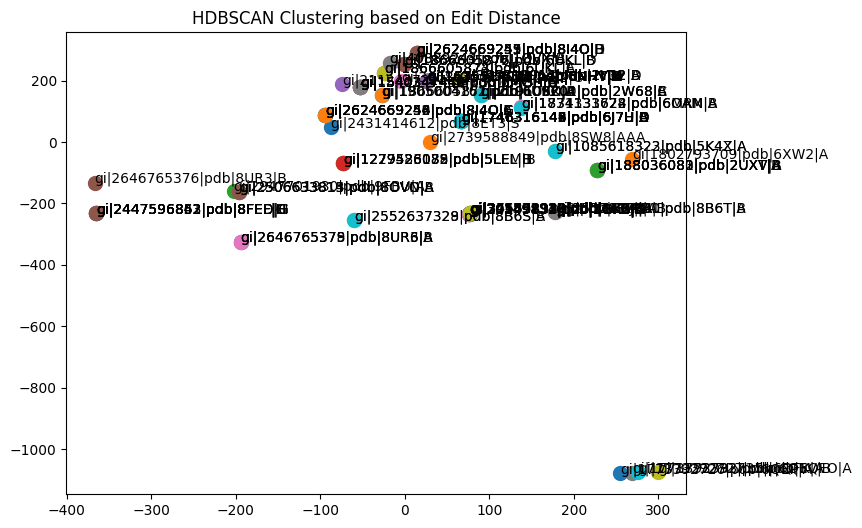

In [13]:
import hdbscan
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# HDBSCAN 클러스터링
clusterer = hdbscan.HDBSCAN(metric='precomputed')
labels = clusterer.fit_predict(distance_matrix)

# MDS를 이용한 2차원 시각화
mds = MDS(dissimilarity='precomputed', random_state=42)
embedding = mds.fit_transform(distance_matrix)

# 시각화
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    plt.scatter(embedding[i][0], embedding[i][1], label=f"Cluster {label}", s=100)
    plt.text(embedding[i][0]+0.01, embedding[i][1]+0.01, sequence_ids[i])
plt.title("HDBSCAN Clustering based on Edit Distance")
plt.show()


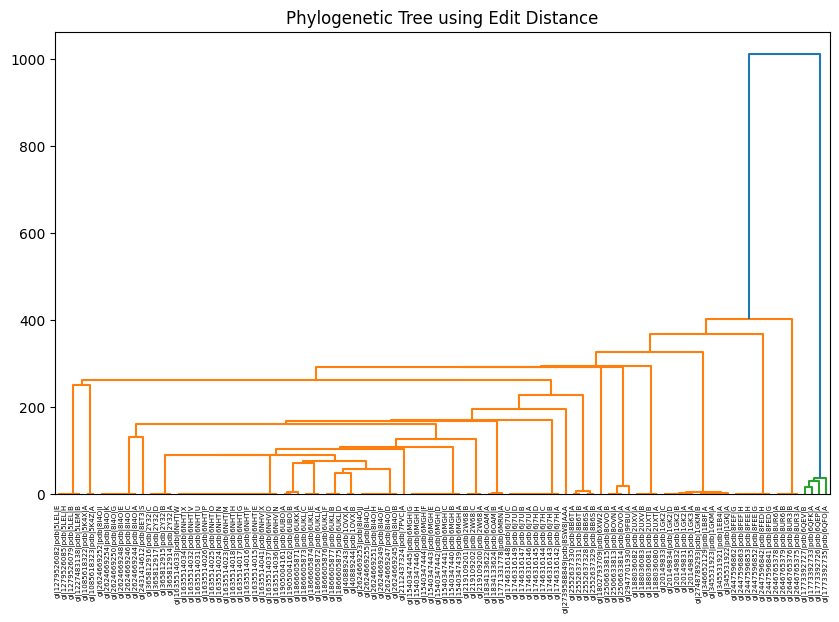

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# condensed distance matrix로 변환
condensed_dist = squareform(distance_matrix)

# 계층적 클러스터링
linked = linkage(condensed_dist, 'single')

# 덴드로그램 시각화
plt.figure(figsize=(10, 6))
dendrogram(linked,
           labels=sequence_ids,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Phylogenetic Tree using Edit Distance")
plt.show()
